In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

import dlib
import face_recognition
from facenet_pytorch import MTCNN
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

C:\Users\blue_\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Memory: 8.00 GB


Model Architecture Comparison for BMI Prediction:

**ResNet-50** (Our Choice)
   - Pros: Excellent feature extraction, proven performance on face tasks
   - Cons: Moderate size (25.6M params)
   - Memory: ~100MB

In [4]:
# configuration
DATA_PATH = r"C:\Users\blue_\Documents\Python\Data"
IMAGE_PATH = os.path.join(DATA_PATH, "BMI\Data\Images")
CSV_PATH = os.path.join(DATA_PATH, "BMI\Data\data.csv")

df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
print(f"Gender distribution:\n{df['gender'].value_counts()}")
print(f"BMI statistics:\n{df['bmi'].describe()}")

# Check for missing images
missing_images = []
for idx, row in df.iterrows():
    img_path = os.path.join(IMAGE_PATH, row['name'])
    if not os.path.exists(img_path):
        missing_images.append(row['name'])

print(f"\nMissing images: {len(missing_images)}")
if missing_images:
    df = df[~df['name'].isin(missing_images)]
    print(f"Samples after removing missing images: {len(df)}")

Total samples: 4206
Gender distribution:
gender
Male      2438
Female    1768
Name: count, dtype: int64
BMI statistics:
count    4206.000000
mean       32.796210
std         8.299130
min        17.716216
25%        26.541837
50%        31.323409
75%        37.577261
max        85.987061
Name: bmi, dtype: float64

Missing images: 244
Samples after removing missing images: 3962


In [ ]:
# Face Detection and Alignment
class FaceProcessor:
    """Handles face detection, alignment, and preprocessing"""
    
    def __init__(self, detector='mtcnn'):
        if detector == 'mtcnn':
            self.detector = MTCNN(keep_all=False, post_process=False, device=device)
        else:
            self.detector = dlib.get_frontal_face_detector()
            self.predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    def detect_and_align(self, image_path, target_size=(224, 224)):
        """Detect face and align based on eye positions"""
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect face
            faces, probs, landmarks = self.detector.detect(img_rgb, landmarks=True)
            
            if faces is None or len(faces) == 0:
                # Fallback: return center crop
                h, w = img.shape[:2]
                size = min(h, w)
                y = (h - size) // 2
                x = (w - size) // 2
                face = img[y:y+size, x:x+size]
                return cv2.resize(face, target_size)
            
            # Get the first face
            face_box = faces[0].astype(int)
            face_landmarks = landmarks[0]
            
            # Calculate eye centers for alignment
            left_eye = face_landmarks[0]
            right_eye = face_landmarks[1]
            
            # Calculate angle for alignment
            dy = right_eye[1] - left_eye[1]
            dx = right_eye[0] - left_eye[0]
            angle = np.degrees(np.arctan2(dy, dx))
            
            # Get face center
            eye_center = ((left_eye[0] + right_eye[0]) // 2,
                         (left_eye[1] + right_eye[1]) // 2)
            
            # Rotate image to align eyes horizontally
            M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
            aligned = cv2.warpAffine(img_rgb, M, (img.shape[1], img.shape[0]))
            
            # Extract face with padding
            x1, y1, x2, y2 = face_box
            w = x2 - x1
            h = y2 - y1
            
            # Add 20% padding
            padding = 0.2
            x1 = max(0, int(x1 - w * padding))
            y1 = max(0, int(y1 - h * padding))
            x2 = min(aligned.shape[1], int(x2 + w * padding))
            y2 = min(aligned.shape[0], int(y2 + h * padding))
            
            face = aligned[y1:y2, x1:x2]
            
            # Resize to target size
            face = cv2.resize(face, target_size)
            
            return face
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

face_processor = FaceProcessor()

In [6]:
class BMIDataset(Dataset):
    """Custom dataset for BMI prediction with face alignment and augmentation"""
    
    def __init__(self, dataframe, image_dir, face_processor, transform=None, 
                 augment=False, cache_processed=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.face_processor = face_processor
        self.transform = transform
        self.augment = augment
        self.cache_processed = cache_processed
        self.cache = {} if cache_processed else None
        
        # Gender encoding
        self.gender_map = {'Male': 0, 'Female': 1}
        
        # Define augmentation pipeline
        self.augmentation = transforms.Compose([
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                 saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), 
                                  scale=(0.9, 1.1)),
            transforms.RandomGrayscale(p=0.1),
        ]) if augment else None
        
        # Normalization (ImageNet stats)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['name'])
        
        # Try to get from cache
        if self.cache_processed and img_path in self.cache:
            face = self.cache[img_path].copy()
        else:
            # Process face
            face = self.face_processor.detect_and_align(img_path)
            if face is None:
                # Fallback: load and resize directly
                img = cv2.imread(img_path)
                face = cv2.resize(img, (224, 224))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            
            if self.cache_processed:
                self.cache[img_path] = face.copy()
        
        # Convert to PIL Image
        face = Image.fromarray(face.astype('uint8'))
        
        # Apply augmentation if training
        if self.augment and self.augmentation:
            face = self.augmentation(face)
        
        # Convert to tensor and normalize
        face = transforms.ToTensor()(face)
        face = self.normalize(face)
        
        # Get labels
        bmi = torch.tensor(row['bmi'], dtype=torch.float32)
        gender = torch.tensor(self.gender_map[row['gender']], dtype=torch.long)
        
        return face, bmi, gender

In [ ]:
# Multi-Task ResNet Model with Gender Branch
class BMIGenderNet(nn.Module):
    """
    Multi-task learning model for BMI regression and gender classification.
    Uses shared ResNet backbone with task-specific heads.
    """
    
    def __init__(self, backbone='resnet50', pretrained=True, 
                 freeze_blocks=2, dropout_rate=0.5):
        super(BMIGenderNet, self).__init__()
        
        # Load pretrained backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            feat_dim = 2048
        elif backbone == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
            feat_dim = 512
        elif backbone == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            feat_dim = 1280
        
        # Freeze early layers
        if backbone.startswith('resnet'):
            # Freeze conv1, bn1, relu, maxpool, and early residual blocks
            modules = [self.backbone.conv1, self.backbone.bn1, 
                      self.backbone.layer1, self.backbone.layer2]
            if freeze_blocks >= 3:
                modules.append(self.backbone.layer3)
            
            for module in modules:
                for param in module.parameters():
                    param.requires_grad = False
        
        # Remove the final classification layer
        if backbone.startswith('resnet'):
            self.backbone.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            self.backbone.classifier = nn.Identity()
        
        # Shared feature processing
        self.shared_fc = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # BMI regression head
        self.bmi_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Gender classification head
        self.gender_head = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        # Extract features from backbone
        features = self.backbone(x)
        
        # Shared processing
        shared_features = self.shared_fc(features)
        
        # Task-specific outputs
        bmi = self.bmi_head(shared_features)
        gender = self.gender_head(shared_features)
        
        return bmi.squeeze(), gender

In [8]:
# Training configuration
class MultiTaskLoss(nn.Module):
    """Combined loss for BMI regression and gender classification"""
    
    def __init__(self, bmi_weight=1.0, gender_weight=0.3):
        super(MultiTaskLoss, self).__init__()
        self.bmi_weight = bmi_weight
        self.gender_weight = gender_weight
        self.bmi_loss = nn.MSELoss()
        self.gender_loss = nn.CrossEntropyLoss()
        
    def forward(self, bmi_pred, gender_pred, bmi_true, gender_true):
        # BMI loss (MSE)
        loss_bmi = self.bmi_loss(bmi_pred, bmi_true)
        
        # Gender loss (Cross-entropy)
        loss_gender = self.gender_loss(gender_pred, gender_true)
        
        # Combined loss
        total_loss = self.bmi_weight * loss_bmi + self.gender_weight * loss_gender
        
        return total_loss, loss_bmi, loss_gender


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, 
                learning_rate=1e-4, device='cuda'):
    """
    Train the model with mixed precision training for faster computation
    """
    model.to(device)
    
    # Multi-task loss
    criterion = MultiTaskLoss(bmi_weight=1.0, gender_weight=0.3)
    
    # Optimizer with different learning rates for backbone and heads
    backbone_params = []
    head_params = []
    
    for name, param in model.named_parameters():
        if 'backbone' in name and param.requires_grad:
            backbone_params.append(param)
        else:
            head_params.append(param)
    
    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': learning_rate * 0.1},
        {'params': head_params, 'lr': learning_rate}
    ], weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_bmi_loss': [], 'val_bmi_loss': [],
        'train_gender_acc': [], 'val_gender_acc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_bmi_loss = 0
        train_gender_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (images, bmi_true, gender_true) in enumerate(pbar):
            images = images.to(device)
            bmi_true = bmi_true.to(device)
            gender_true = gender_true.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                bmi_pred, gender_pred = model(images)
                loss, loss_bmi, loss_gender = criterion(
                    bmi_pred, gender_pred, bmi_true, gender_true
                )
            
            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            train_loss += loss.item()
            train_bmi_loss += loss_bmi.item()
            
            _, gender_predicted = torch.max(gender_pred.data, 1)
            train_total += gender_true.size(0)
            train_gender_correct += (gender_predicted == gender_true).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'bmi_loss': f'{loss_bmi.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_bmi_loss = 0
        val_gender_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, bmi_true, gender_true in val_loader:
                images = images.to(device)
                bmi_true = bmi_true.to(device)
                gender_true = gender_true.to(device)
                
                with torch.cuda.amp.autocast():
                    bmi_pred, gender_pred = model(images)
                    loss, loss_bmi, loss_gender = criterion(
                        bmi_pred, gender_pred, bmi_true, gender_true
                    )
                
                val_loss += loss.item()
                val_bmi_loss += loss_bmi.item()
                
                _, gender_predicted = torch.max(gender_pred.data, 1)
                val_total += gender_true.size(0)
                val_gender_correct += (gender_predicted == gender_true).sum().item()
        
        # Calculate epoch statistics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_bmi_loss = train_bmi_loss / len(train_loader)
        avg_val_bmi_loss = val_bmi_loss / len(val_loader)
        train_gender_acc = 100 * train_gender_correct / train_total
        val_gender_acc = 100 * val_gender_correct / val_total
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_bmi_loss'].append(avg_train_bmi_loss)
        history['val_bmi_loss'].append(avg_val_bmi_loss)
        history['train_gender_acc'].append(train_gender_acc)
        history['val_gender_acc'].append(val_gender_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Train BMI Loss: {avg_train_bmi_loss:.4f}, Val BMI Loss: {avg_val_bmi_loss:.4f}')
        print(f'Train Gender Acc: {train_gender_acc:.2f}%, Val Gender Acc: {val_gender_acc:.2f}%')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_bmi_model_ResNet.pth')
            print('Saved best model!')
        
        scheduler.step()
    
    return history

In [ ]:
male_df = df[df['gender'] == 'Male']
female_df = df[df['gender'] == 'Female']

male_train, male_test = train_test_split(
    male_df, test_size=0.2, random_state=42
)
female_train, female_test = train_test_split(
    female_df, test_size=0.2, random_state=42
)

# Combine
train_df = pd.concat([male_train, female_train]).reset_index(drop=True)
test_df = pd.concat([male_test, female_test]).reset_index(drop=True)

print(f"Training samples: {len(train_df)} (Male: {len(male_train)}, Female: {len(female_train)})")
print(f"Test samples: {len(test_df)} (Male: {len(male_test)}, Female: {len(female_test)})")

# Create datasets
train_dataset = BMIDataset(train_df, IMAGE_PATH, face_processor, augment=True)
test_dataset = BMIDataset(test_df, IMAGE_PATH, face_processor, augment=False)

# Create data loaders
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                         shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=0, pin_memory=True)

Training samples: 3169 (Male: 1883, Female: 1286)
Test samples: 793 (Male: 471, Female: 322)


In [ ]:
# Starting training
model = BMIGenderNet(backbone='resnet50', pretrained=True, 
                     freeze_blocks=2, dropout_rate=0.5)

print("Starting training...")
history = train_model(model, train_loader, test_loader, 
                     num_epochs=30, learning_rate=1e-4, device=device)

Starting training...


Epoch 1/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/30:
Train Loss: 622.8011, Val Loss: 94.1908
Train BMI Loss: 622.5278, Val BMI Loss: 93.9801
Train Gender Acc: 51.06%, Val Gender Acc: 59.39%
Saved best model!


Epoch 2/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2/30:
Train Loss: 79.5435, Val Loss: 52.6469
Train BMI Loss: 79.2618, Val BMI Loss: 52.4397
Train Gender Acc: 53.80%, Val Gender Acc: 59.39%
Saved best model!


Epoch 3/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3/30:
Train Loss: 71.4008, Val Loss: 54.6434
Train BMI Loss: 71.1694, Val BMI Loss: 54.4404
Train Gender Acc: 55.79%, Val Gender Acc: 59.39%


Epoch 4/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4/30:
Train Loss: 68.4264, Val Loss: 58.0730
Train BMI Loss: 68.2030, Val BMI Loss: 57.8699
Train Gender Acc: 54.65%, Val Gender Acc: 59.39%


Epoch 5/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5/30:
Train Loss: 60.4744, Val Loss: 51.7692
Train BMI Loss: 60.2595, Val BMI Loss: 51.5655
Train Gender Acc: 53.83%, Val Gender Acc: 59.39%
Saved best model!


Epoch 6/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 6/30:
Train Loss: 57.9085, Val Loss: 58.0609
Train BMI Loss: 57.6976, Val BMI Loss: 57.8547
Train Gender Acc: 56.11%, Val Gender Acc: 58.64%


Epoch 7/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 7/30:
Train Loss: 56.1804, Val Loss: 51.3808
Train BMI Loss: 55.9697, Val BMI Loss: 51.1746
Train Gender Acc: 54.59%, Val Gender Acc: 59.02%
Saved best model!


Epoch 8/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 8/30:
Train Loss: 56.2219, Val Loss: 46.0213
Train BMI Loss: 56.0130, Val BMI Loss: 45.8149
Train Gender Acc: 56.17%, Val Gender Acc: 58.01%
Saved best model!


Epoch 9/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 9/30:
Train Loss: 55.1875, Val Loss: 48.1528
Train BMI Loss: 54.9802, Val BMI Loss: 47.9476
Train Gender Acc: 56.96%, Val Gender Acc: 59.39%


Epoch 10/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 10/30:
Train Loss: 52.4035, Val Loss: 50.1556
Train BMI Loss: 52.1982, Val BMI Loss: 49.9512
Train Gender Acc: 57.18%, Val Gender Acc: 59.39%


Epoch 11/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 11/30:
Train Loss: 49.6740, Val Loss: 52.6011
Train BMI Loss: 49.4660, Val BMI Loss: 52.3963
Train Gender Acc: 57.02%, Val Gender Acc: 59.39%


Epoch 12/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 12/30:
Train Loss: 52.0980, Val Loss: 49.9041
Train BMI Loss: 51.8923, Val BMI Loss: 49.7002
Train Gender Acc: 57.75%, Val Gender Acc: 59.39%


Epoch 13/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 13/30:
Train Loss: 49.5270, Val Loss: 52.9595
Train BMI Loss: 49.3233, Val BMI Loss: 52.7558
Train Gender Acc: 58.91%, Val Gender Acc: 59.39%


Epoch 14/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 14/30:
Train Loss: 46.0359, Val Loss: 52.1362
Train BMI Loss: 45.8312, Val BMI Loss: 51.9318
Train Gender Acc: 57.46%, Val Gender Acc: 59.39%


Epoch 15/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 15/30:
Train Loss: 44.9828, Val Loss: 55.0481
Train BMI Loss: 44.7765, Val BMI Loss: 54.8441
Train Gender Acc: 57.65%, Val Gender Acc: 59.39%


Epoch 16/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 16/30:
Train Loss: 45.8307, Val Loss: 55.9892
Train BMI Loss: 45.6260, Val BMI Loss: 55.7859
Train Gender Acc: 58.19%, Val Gender Acc: 59.39%


Epoch 17/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 17/30:
Train Loss: 42.3930, Val Loss: 52.0222
Train BMI Loss: 42.1873, Val BMI Loss: 51.8183
Train Gender Acc: 58.22%, Val Gender Acc: 59.39%


Epoch 18/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 18/30:
Train Loss: 42.8807, Val Loss: 49.3024
Train BMI Loss: 42.6763, Val BMI Loss: 49.0987
Train Gender Acc: 57.56%, Val Gender Acc: 59.39%


Epoch 19/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 19/30:
Train Loss: 43.2203, Val Loss: 50.6649
Train BMI Loss: 43.0168, Val BMI Loss: 50.4615
Train Gender Acc: 58.25%, Val Gender Acc: 59.39%


Epoch 20/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 20/30:
Train Loss: 40.5067, Val Loss: 54.7147
Train BMI Loss: 40.3015, Val BMI Loss: 54.5109
Train Gender Acc: 58.79%, Val Gender Acc: 59.39%


Epoch 21/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 21/30:
Train Loss: 40.5569, Val Loss: 53.5801
Train BMI Loss: 40.3523, Val BMI Loss: 53.3762
Train Gender Acc: 58.13%, Val Gender Acc: 59.39%


Epoch 22/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 22/30:
Train Loss: 41.2422, Val Loss: 49.5825
Train BMI Loss: 41.0381, Val BMI Loss: 49.3786
Train Gender Acc: 58.13%, Val Gender Acc: 59.39%


Epoch 23/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 23/30:
Train Loss: 40.1122, Val Loss: 47.0729
Train BMI Loss: 39.9076, Val BMI Loss: 46.8693
Train Gender Acc: 58.38%, Val Gender Acc: 59.39%


Epoch 24/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 24/30:
Train Loss: 40.6932, Val Loss: 56.5623
Train BMI Loss: 40.4876, Val BMI Loss: 56.3586
Train Gender Acc: 58.50%, Val Gender Acc: 59.39%


Epoch 25/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 25/30:
Train Loss: 39.4814, Val Loss: 53.3344
Train BMI Loss: 39.2773, Val BMI Loss: 53.1309
Train Gender Acc: 58.82%, Val Gender Acc: 59.39%


Epoch 26/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 26/30:
Train Loss: 37.3701, Val Loss: 50.7979
Train BMI Loss: 37.1653, Val BMI Loss: 50.5944
Train Gender Acc: 58.19%, Val Gender Acc: 59.39%


Epoch 27/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 27/30:
Train Loss: 38.5834, Val Loss: 51.4217
Train BMI Loss: 38.3797, Val BMI Loss: 51.2181
Train Gender Acc: 59.04%, Val Gender Acc: 59.39%


Epoch 28/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 28/30:
Train Loss: 38.9315, Val Loss: 54.8716
Train BMI Loss: 38.7271, Val BMI Loss: 54.6681
Train Gender Acc: 58.76%, Val Gender Acc: 59.39%


Epoch 29/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 29/30:
Train Loss: 39.9336, Val Loss: 49.5851
Train BMI Loss: 39.7292, Val BMI Loss: 49.3817
Train Gender Acc: 58.35%, Val Gender Acc: 59.39%


Epoch 30/30:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 30/30:
Train Loss: 40.6236, Val Loss: 46.6897
Train BMI Loss: 40.4201, Val BMI Loss: 46.4861
Train Gender Acc: 58.50%, Val Gender Acc: 59.39%


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


=== Evaluation Results ===

Overall Performance:
  Pearson r: 0.6061
  MAE: 4.96
  R²: 0.3284

Male-specific Performance:
  Pearson r: 0.6645
  MAE: 4.46

Female-specific Performance:
  Pearson r: 0.5322
  MAE: 5.69

Gender Classification Accuracy: 58.01%


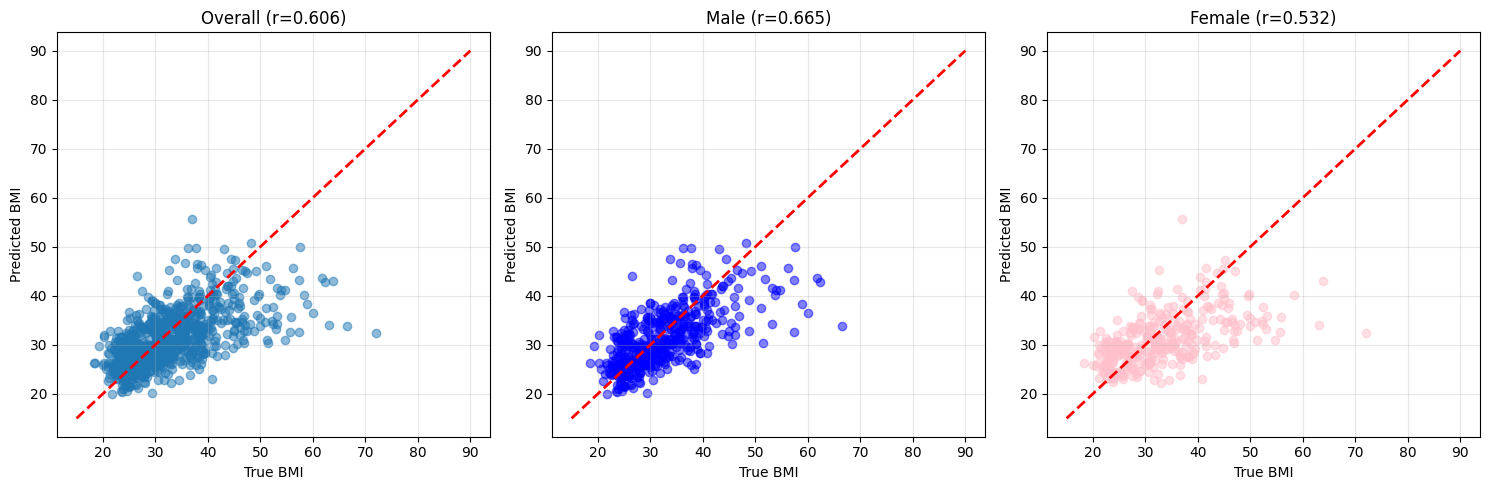

In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    """Comprehensive evaluation with gender-specific metrics"""
    model.eval()
    model.to(device)
    
    all_bmi_true = []
    all_bmi_pred = []
    all_gender_true = []
    all_gender_pred = []
    
    with torch.no_grad():
        for images, bmi_true, gender_true in tqdm(test_loader, desc='Evaluating'):
            images = images.to(device)
            
            with torch.cuda.amp.autocast():
                bmi_pred, gender_pred = model(images)
            
            all_bmi_true.extend(bmi_true.cpu().numpy())
            all_bmi_pred.extend(bmi_pred.cpu().numpy())
            all_gender_true.extend(gender_true.cpu().numpy())
            all_gender_pred.extend(torch.argmax(gender_pred, dim=1).cpu().numpy())
    
    # Convert to numpy arrays
    all_bmi_true = np.array(all_bmi_true)
    all_bmi_pred = np.array(all_bmi_pred)
    all_gender_true = np.array(all_gender_true)
    all_gender_pred = np.array(all_gender_pred)
    
    # Overall metrics
    overall_r, _ = pearsonr(all_bmi_true, all_bmi_pred)
    overall_mae = mean_absolute_error(all_bmi_true, all_bmi_pred)
    overall_r2 = r2_score(all_bmi_true, all_bmi_pred)
    
    # Gender-specific metrics
    male_mask = all_gender_true == 0
    female_mask = all_gender_true == 1
    
    male_r, _ = pearsonr(all_bmi_true[male_mask], all_bmi_pred[male_mask])
    female_r, _ = pearsonr(all_bmi_true[female_mask], all_bmi_pred[female_mask])
    
    male_mae = mean_absolute_error(all_bmi_true[male_mask], all_bmi_pred[male_mask])
    female_mae = mean_absolute_error(all_bmi_true[female_mask], all_bmi_pred[female_mask])
    
    # Gender classification accuracy
    gender_acc = np.mean(all_gender_true == all_gender_pred) * 100
    
    # Print results
    print("\n=== Evaluation Results ===")
    print(f"\nOverall Performance:")
    print(f"  Pearson r: {overall_r:.4f}")
    print(f"  MAE: {overall_mae:.2f}")
    print(f"  R²: {overall_r2:.4f}")
    
    print(f"\nMale-specific Performance:")
    print(f"  Pearson r: {male_r:.4f}")
    print(f"  MAE: {male_mae:.2f}")
    
    print(f"\nFemale-specific Performance:")
    print(f"  Pearson r: {female_r:.4f}")
    print(f"  MAE: {female_mae:.2f}")
    
    print(f"\nGender Classification Accuracy: {gender_acc:.2f}%")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Overall scatter plot
    axes[0].scatter(all_bmi_true, all_bmi_pred, alpha=0.5)
    axes[0].plot([15, 90], [15, 90], 'r--', lw=2)
    axes[0].set_xlabel('True BMI')
    axes[0].set_ylabel('Predicted BMI')
    axes[0].set_title(f'Overall (r={overall_r:.3f})')
    axes[0].grid(True, alpha=0.3)
    
    # Male scatter plot
    axes[1].scatter(all_bmi_true[male_mask], all_bmi_pred[male_mask], 
                   alpha=0.5, color='blue')
    axes[1].plot([15, 90], [15, 90], 'r--', lw=2)
    axes[1].set_xlabel('True BMI')
    axes[1].set_ylabel('Predicted BMI')
    axes[1].set_title(f'Male (r={male_r:.3f})')
    axes[1].grid(True, alpha=0.3)
    
    # Female scatter plot
    axes[2].scatter(all_bmi_true[female_mask], all_bmi_pred[female_mask], 
                   alpha=0.5, color='pink')
    axes[2].plot([15, 90], [15, 90], 'r--', lw=2)
    axes[2].set_xlabel('True BMI')
    axes[2].set_ylabel('Predicted BMI')
    axes[2].set_title(f'Female (r={female_r:.3f})')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'overall_r': overall_r,
        'male_r': male_r,
        'female_r': female_r,
        'overall_mae': overall_mae,
        'male_mae': male_mae,
        'female_mae': female_mae,
        'gender_accuracy': gender_acc
    }

# Load best model and evaluate
model.load_state_dict(torch.load('best_bmi_model_ResNet.pth'))
results = evaluate_model(model, test_loader, device)

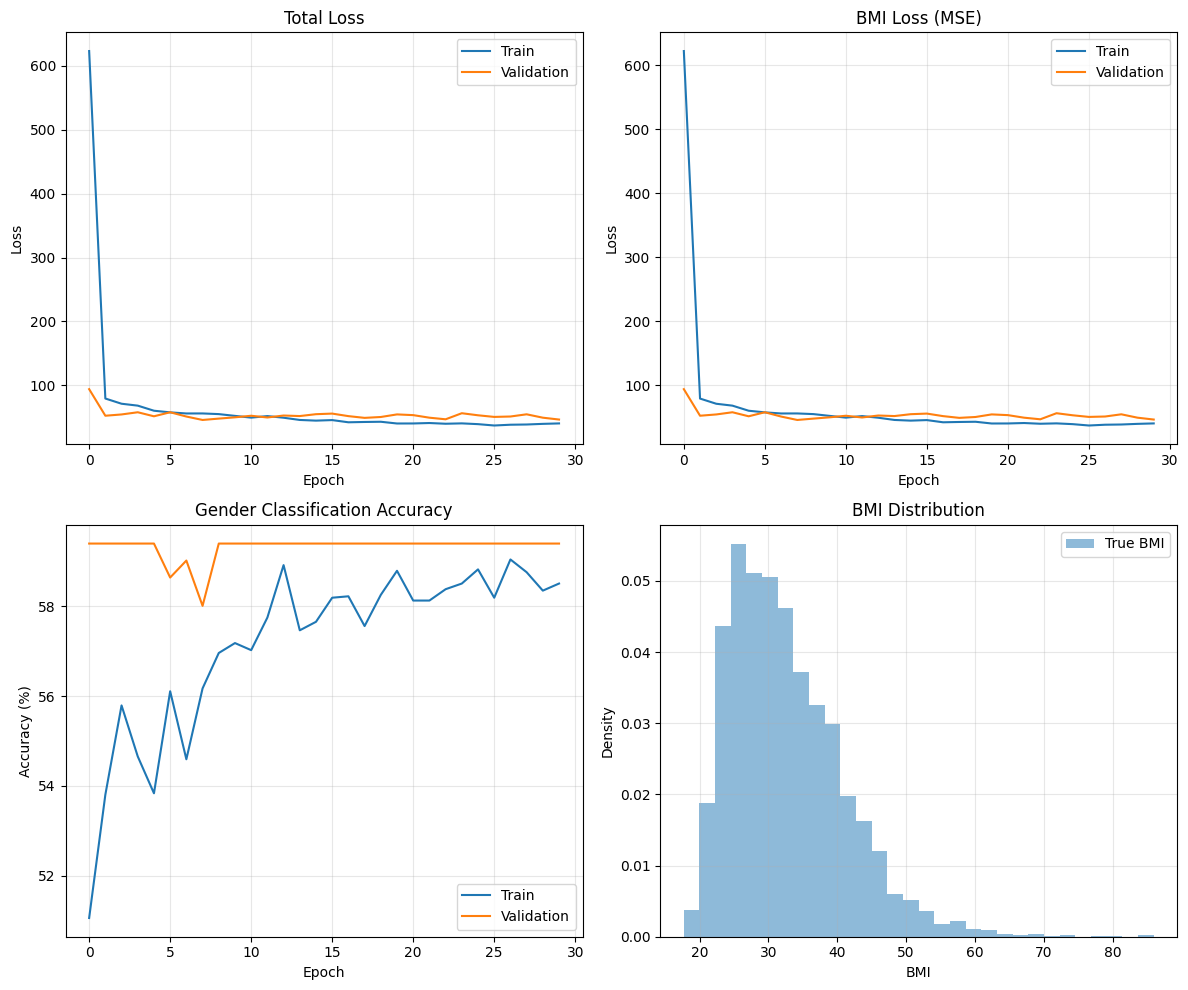

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# BMI loss
axes[0, 1].plot(history['train_bmi_loss'], label='Train')
axes[0, 1].plot(history['val_bmi_loss'], label='Validation')
axes[0, 1].set_title('BMI Loss (MSE)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gender accuracy
axes[1, 0].plot(history['train_gender_acc'], label='Train')
axes[1, 0].plot(history['val_gender_acc'], label='Validation')
axes[1, 0].set_title('Gender Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# BMI distribution comparison
axes[1, 1].hist(df['bmi'], bins=30, alpha=0.5, label='True BMI', density=True)
axes[1, 1].set_title('BMI Distribution')
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()